### Data Sourcing
Obtain the data from 1 Oct 2012 to 30 September 2022 for the following: (say)
2012-10-01 to 2022-09-30
1. SPY (SPDR S & P 500 ETF)
2. XLE (Energy Sector SPDR)
3. VNQ (Real Estate)
4. XLF (Finance Sector SPDR)

In [24]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

In [25]:
yahoo_financials = YahooFinancials('SPY')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
spy_df = pd.DataFrame(data['SPY']['prices'])
spy_df = spy_df.drop('date', axis=1).set_index('formatted_date')
spy_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,147.160004,143.830002,144.520004,146.139999,619770200,120.519783
2012-10-08,146.119995,142.580002,145.600006,142.889999,599319200,117.839569
2012-10-15,146.520004,142.770004,143.229996,143.389999,679092400,118.251930
2012-10-22,143.669998,140.389999,143.149994,141.350006,718295200,116.569557
2012-10-29,143.720001,140.679993,141.850006,141.559998,342136300,116.742752


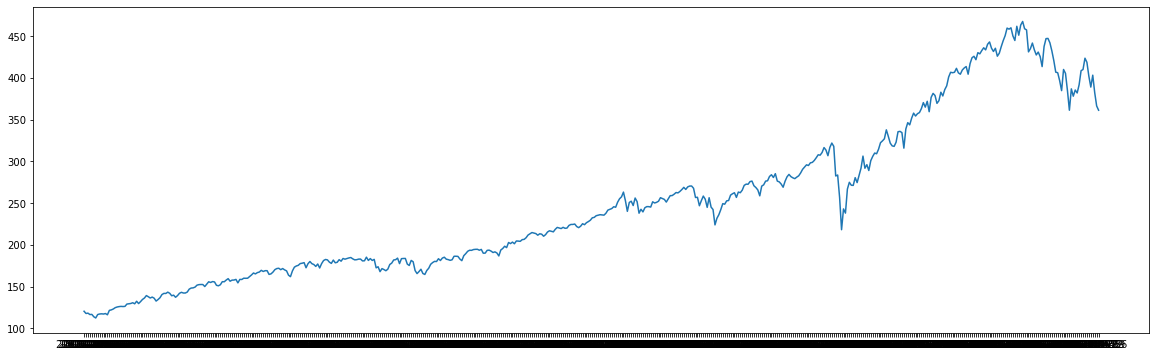

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,6));
ax.plot(spy_df['adjclose']);

In [26]:
yahoo_financials = YahooFinancials('XLE')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
xle_df = pd.DataFrame(data['XLE']['prices'])
xle_df = xle_df.drop('date', axis=1).set_index('formatted_date')
xle_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,74.529999,72.669998,73.940002,73.580002,57754800,50.376877
2012-10-08,74.379997,72.040001,73.169998,72.559998,49958700,49.678543
2012-10-15,75.190002,71.910004,72.430000,73.830002,60294000,50.548058
2012-10-22,74.099998,71.019997,73.860001,71.959999,57769500,49.267746
2012-10-29,72.690002,70.820000,72.250000,71.059998,31881500,48.651554


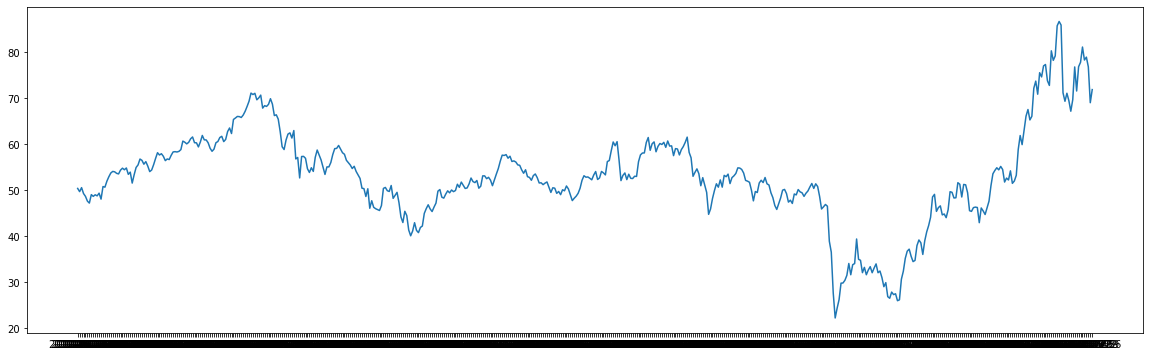

In [51]:
fig, ax = plt.subplots(figsize=(20,6));
ax.plot(xle_df['adjclose']);

In [27]:
yahoo_financials = YahooFinancials('VNQ')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
vnq_df = pd.DataFrame(data['VNQ']['prices'])
vnq_df = vnq_df.drop('date', axis=1).set_index('formatted_date')
vnq_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,65.680000,63.820000,65.099998,65.169998,14488300,43.299465
2012-10-08,65.529999,64.680000,64.830002,64.769997,9381600,43.033699
2012-10-15,66.320000,64.459999,64.790001,65.540001,11433000,43.545292
2012-10-22,65.550003,63.400002,65.489998,63.759998,9668400,42.362640
2012-10-29,65.570000,63.740002,64.040001,65.120003,7515200,43.266247


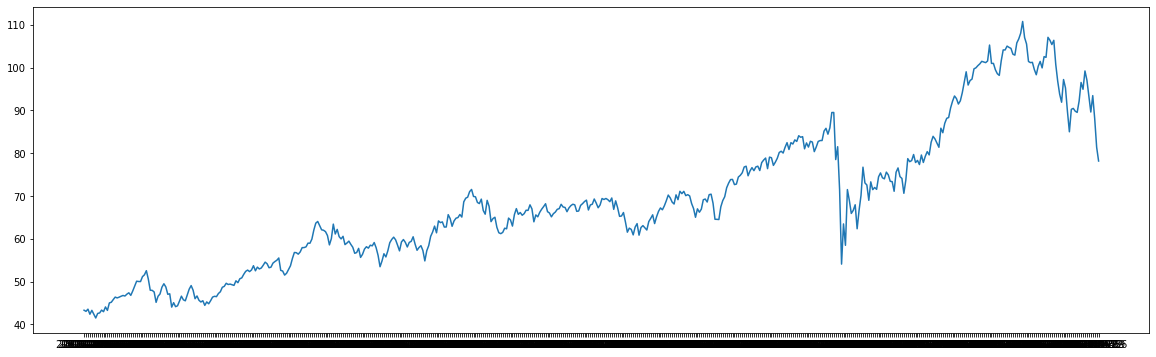

In [52]:
fig, ax = plt.subplots(figsize=(20,6));
ax.plot(vnq_df['adjclose']);

In [28]:
yahoo_financials = YahooFinancials('XLF')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
xlf_df = pd.DataFrame(data['XLF']['prices'])
xlf_df = xlf_df.drop('date', axis=1).set_index('formatted_date')
xlf_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,13.184403,12.688871,12.753859,13.046304,360107630,10.720537
2012-10-08,13.103168,12.802600,12.981316,12.843217,370064697,10.553655
2012-10-15,13.314379,12.835093,12.891958,13.086921,372740399,10.753912
2012-10-22,13.119415,12.745735,13.070674,12.835093,408311252,10.546977
2012-10-29,13.160032,12.826970,12.883834,12.997563,191163467,10.680484


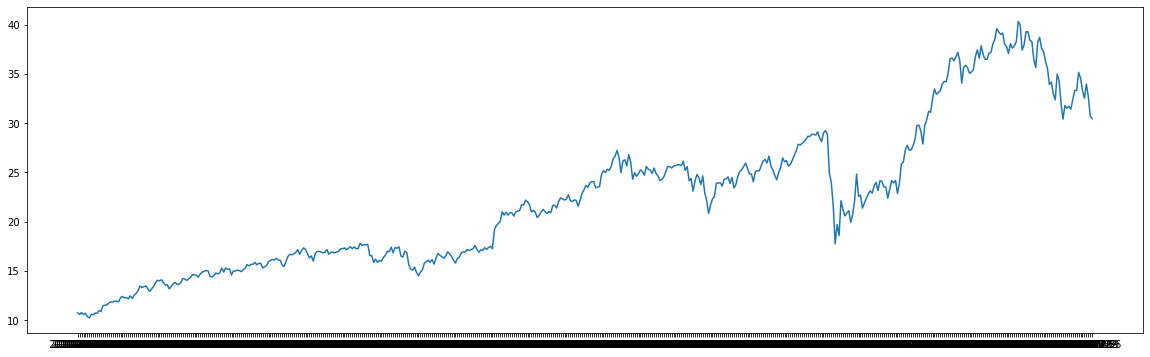

In [53]:
fig, ax = plt.subplots(figsize=(20,6));
ax.plot(xlf_df['adjclose']);

In [29]:
yahoo_financials = YahooFinancials('MSCI')
data = yahoo_financials.get_historical_price_data(start_date='2012-10-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
msci_df = pd.DataFrame(data['MSCI']['prices'])
msci_df = msci_df.drop('date', axis=1).set_index('formatted_date')
msci_df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2012-10-01,36.040001,24.770000,35.970001,26.860001,26641600,24.528347
2012-10-08,26.820000,25.719999,26.740000,25.930000,5655400,23.679075
2012-10-15,27.920000,25.459999,26.129999,27.020000,9857100,24.674454
2012-10-22,27.620001,26.700001,26.860001,27.540001,3182200,25.149317
2012-10-29,28.040001,26.790001,27.510000,26.879999,2933200,24.546610


### Data Sources for various rates
Macroeconomic indicators as follows for the same time period:
1. Fed Fund effective rates
2. Bank loan rates 
3. Unemployment rates

In [30]:
from fredapi import Fred
# FRED API key
fred_key = "0e42125b8d25e5d7a6b4f26132eb7b1e";
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);
# Retrieve data from FRED API

fed_effective_rates_df = pd.DataFrame(fred.get_series('FEDFUNDS'));

In [31]:
fed_effective_rates_df.head()

,0
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83


In [32]:
bank_loan_rates_df = pd.DataFrame(fred.get_series('DPRIME'));

In [33]:
bank_loan_rates_df.head()

,0
1955-08-04,3.25
1955-08-05,3.25
1955-08-08,3.25
1955-08-09,3.25
1955-08-10,3.25


In [34]:
unemployment_rates_df = pd.DataFrame(fred.get_series('UNRATE'));

In [35]:
unemployment_rates_df.head()

,0
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


#### Importing the libraries

In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas_datareader import data
from datetime import datetime, timedelta
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [37]:
from bioinfokit.visuz import cluster
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tsa.stattools as ts

In [38]:
from copulas.datasets import sample_trivariate_xyz
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_2d,compare_3d,scatter_2d,hist_1d, side_by_side
from copulas.multivariate import VineCopula

In [39]:
#Warning removal:
import warnings
warnings.filterwarnings('ignore')

#### Combined Data Sourcing

In [40]:
# Between Oct,2012 and Oct,2022
start_date=datetime(2012,10,1)-timedelta(days=185)
end_date=datetime(2022,9,30)+timedelta(days=185)
#EFTs
#Vanguard Real Estate Index Fund(VNQ)
#SPDR S&P 500 ETF (SPY)
#Financial Select Sector SPDR® Fund(XLF)
#Energy Select Sector SPDR® Fund(XLE)
etf_ticker=['VNQ','SPY','XLF','XLE']

yahoo_financials = YahooFinancials(etf_ticker)
etf_data = yahoo_financials.get_historical_price_data(start_date='2012-04-01', 
                                                  end_date='2022-09-30', 
                                                  time_interval='weekly')
#etf_data = data.DataReader(etf_ticker, 'yahoo', start=start_date, end=end_date)
# Can be resampled as below:
#security_data_resampled = etf_data['Adj Close'].resample("MS").mean()

#### Resampling

In [41]:
#TBD

#### Gathering data from Fred for Indicators purpose

In [42]:
#TBD

### Data Display
#### Plotting for Outliers

In [43]:
# TBD
# Boxplot
# Correlation heat map

##### Cluster correlation analysis

In [44]:
# TBD
# cluster correlation matrix
# Scatter plot
# Time series plot
# Density plot


#### Calculating Daily Returns

In [45]:
# TBD

In [46]:
# PCA Analsis
# Extreme value tracing
# Modelling Data
## QQ Plot normalization
# Jorgue -Berra Test
# QQ Plot normalization 

# Gaussian F-test
# Normalization test
# 

## Model - fitting
# Copula
# Gaussian Copula
# Normal distribution
# Non Gaussian Copula
# Model Vine Copula
# 

## Regime Tests
#  Get data 
# CADF model function
# mean reverting relationship
# 